# Feature Generation
We use linear combination, wavelet transformation, 

In [1]:
import os, pickle
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, LSTM, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from data_reader import DataLoader
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA
import pandas as pd
import tqdm

N = 10
seq_len = 30
sample_gap = 30

Using TensorFlow backend.


### First we try to use data generated by linear combination

In [9]:
def LSTMModel(train_input, train_label, dev_input, dev_label, test_input, test_label):
    model = Sequential()
    model.add(LSTM(128, input_length=train_input.shape[1], input_dim=train_input.shape[2], return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()

    callback = EarlyStopping(monitor="loss", patience=0.01, verbose=1, mode="auto")
    model.fit(train_input, train_label, epochs=3, batch_size=32, validation_data=(dev_input, dev_label), callbacks=[callback])

    LSTMIndicatorPred = model.predict(test_input)
    LSTMacc = np.std(LSTMIndicatorPred - test_label.reshape(test_label.shape[0], 1))
    return LSTMacc

if os.path.exists(path="./raw_data/featuredata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap)):
    with open("./raw_data/featuredata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'rb') as load_data:
        (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = pickle.load(load_data)
else:
    dataset = get_fromcsv(root)
    dataset = clean_data(dataset)
    dataset, labels = get_feature_label(dataset, N, seq_len, sample_gap)
    (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = divid_dataset(dataset, labels)
    with open("./raw_data/featuredata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'wb') as save_data:
        data_list = [(train_input, train_label), (dev_input, dev_label), (test_input, test_label)]
        pickle.dump(data_list, save_data)

train_input = np.array(train_input).reshape(train_input.shape[0], seq_len, -1)
train_label = np.array(train_label)
dev_input = np.array(dev_input).reshape(dev_input.shape[0], seq_len, -1)
dev_label = np.array(dev_label)
test_input = np.array(test_input).reshape(test_input.shape[0], seq_len, -1)
test_label = np.array(test_label)
print(train_input.shape)
accs = []

LSTMacc1 = LSTMModel(train_input, train_label, dev_input, dev_label, test_input, test_label)
print("LSTM: ", LSTMacc1)
accs.append(LSTMacc1)

(15091, 30, 21)


/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, input_shape=(30, 21))`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 128)           76800     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 113,121
Trainable params: 113,121
Non-trainable params: 0
_________________________________________________________________
Train on 15091 samples, validate on 1886 samples
Epoch 1/3
15091/15091 [==============================] - 38s 3ms/step - loss: 2.2239 - val_loss: 2.1747
Epoch 2/3
15091/15091 [==============================] - 33s 2ms/step - loss: 2.2125 - val_loss: 2.1430
Epoch 3/3
1

In [11]:
def CNNmodel(train_input, train_label, dev_input, dev_label, test_input, test_label):
    train_input = train_input.reshape(train_input.shape[0], train_input.shape[1], int(train_input.shape[2] / 3), 3)
    test_input = test_input.reshape(test_input.shape[0], test_input.shape[1], int(test_input.shape[2] / 3), 3)
    dev_input = dev_input.reshape(dev_input.shape[0], dev_input.shape[1], int(dev_input.shape[2] / 3), 3)

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='sigmoid', input_shape=(train_input.shape[1], train_input.shape[2], train_input.shape[3])))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='sigmoid'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid'))
#     model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()

    callback = EarlyStopping(monitor="loss", patience=0.01, verbose=1, mode="auto")
    model.fit(train_input, train_label, epochs=3, batch_size=32, validation_data=(dev_input, dev_label), callbacks=[callback])

    CNNIndicatorPred = model.predict(test_input)
    CNNacc = np.std(CNNIndicatorPred - test_label.reshape(test_label.shape[0], 1))
    return CNNacc

CNNacc1 = CNNmodel(train_input, train_label, dev_input, dev_label, test_input, test_label)
print(CNNacc1)
accs.append(CNNacc1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 5, 32)         896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 3, 32)         9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 1, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 416)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                4170      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 14,325
Trainable params: 14,325
Non-trainable params: 0
_________________________________________________________________
Train 

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

def GBDTRegress(X, y, depth, random_st):
    regr = GradientBoostingRegressor(max_depth=depth, random_state=random_st)
    regr.fit(X, y)
    return regr

train_input = train_input.reshape(train_input.shape[0], -1)
dev_input = dev_input.reshape(dev_input.shape[0], -1)
test_input = test_input.reshape(test_input.shape[0], -1)

regressor = GBDTRegress(train_input, np.array(train_label), 2, 0)

GBDTRawPred = regressor.predict(test_input)
GBDTacc1 = np.std(GBDTRawPred - np.array(test_label))
print("GBDT: ", GBDTacc1)
accs.append(GBDTacc1)

GBDT:  1.6094588567358585


In [14]:
from sklearn.ensemble import RandomForestRegressor

def RandomForestRegress(X, y, depth, random_st, n_estimators):
    regr = RandomForestRegressor(max_depth=depth, random_state=random_st, n_estimators=n_estimators)
    regr.fit(X, y)
    return regr

regressor = RandomForestRegress(train_input, np.array(train_label), 2, 0, 100)

RFRawPred = regressor.predict(test_input)
RFacc1 = np.std(RFRawPred - np.array(test_label))
print("Random Forest: ", RFacc1)
accs.append(RFacc1)

Random Forest:  1.6068420474914324


In [15]:
from sklearn.ensemble import AdaBoostRegressor

def AdaRegress(X, y, n_estimators, random_st):
    regr = AdaBoostRegressor(n_estimators=n_estimators, random_state=random_st)
    regr.fit(X, y)
    return regr

regressor = AdaRegress(train_input, np.array(train_label), 100, 0)

AdaRawPred = regressor.predict(test_input)
AdaBoostacc1 = np.std(AdaRawPred - np.array(test_label))
print("AdaBoost: ", AdaBoostacc1)
accs.append(AdaBoostacc1)

AdaBoost:  1.7902172858739314


### Now we try to use data generated by wavelet transformation

In [20]:
import pywt

def wavelet_denoising(data):
    """
    Doing wavelet transformation for single data

    """
    db4 = pywt.Wavelet('db4')
    coeffs = pywt.wavedec(data, db4)
    coeffs[len(coeffs) - 1] *= 0
    coeffs[len(coeffs) - 2] *= 0
    meta = pywt.waverec(coeffs, db4)
    return meta

def generate_by_wavelet(N, seq_len, sample_gap):
    """
    Generating features by wavelet transformation

    """
    if os.path.exists(path="./raw_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap)):
        with open("./raw_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'rb') as load_data:
            (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = pickle.load(load_data)
    else:
        (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = DataLoader("./data.csv", N, seq_len, sample_gap)
        with open("./raw_data/mydata_{0}_{1}_{2}.pickle".format(N, seq_len, sample_gap), 'wb') as save_data:
            data_list = [(train_input, train_label), (dev_input, dev_label), (test_input, test_label)]
            pickle.dump(data_list, save_data)
            
    train_input = np.array(train_input).reshape(train_input.shape[0], seq_len, -1)
    train_label = np.array(train_label)
    dev_input = np.array(dev_input).reshape(dev_input.shape[0], seq_len, -1)
    dev_label = np.array(dev_label)
    test_input = np.array(test_input).reshape(test_input.shape[0], seq_len, -1)
    test_label = np.array(test_label)
    
    for i in range(train_input.shape[2]):
        train_input[:, :, i] = wavelet_denoising(train_input[:, :, i])
        dev_input[:, :, i] = wavelet_denoising(dev_input[:, :, i])
        test_input[:, :, i] = wavelet_denoising(test_input[:, :, i])

    return train_input, train_label, dev_input, dev_label, test_input, test_label

train_input, train_label, dev_input, dev_label, test_input, test_label = generate_by_wavelet(N, seq_len, sample_gap)
accs2 = []

LSTMacc2 = LSTMModel(train_input, train_label, dev_input, dev_label, test_input, test_label)
print("LSTM: ", LSTMacc2)
accs2.append(LSTMacc2)

/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, input_shape=(30, 108))`
  This is separate from the ipykernel package so we can avoid doing imports until


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30, 128)           121344    
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 157,665
Trainable params: 157,665
Non-trainable params: 0
_________________________________________________________________
Train on 15091 samples, validate on 1886 samples
Epoch 1/3
15091/15091 [==============================] - 68s 5ms/step - loss: 2.2866 - val_loss: 2.2366
Epoch 2/3
15091/15091 [==============================] - 65s 4ms/step - loss: 2.2595 - val_loss: 2.2340
Epoch 3/3
1

In [21]:
CNNacc2 = CNNmodel(train_input, train_label, dev_input, dev_label, test_input, test_label)
print(CNNacc2)
accs2.append(CNNacc2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 34, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 16, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6656)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                66570     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 76,725
Trainable params: 76,725
Non-trainable params: 0
_________________________________________________________________
Train 

In [22]:
train_input = train_input.reshape(train_input.shape[0], -1)
dev_input = dev_input.reshape(dev_input.shape[0], -1)
test_input = test_input.reshape(test_input.shape[0], -1)

regressor = GBDTRegress(train_input, np.array(train_label), 2, 0)

GBDTRawPred = regressor.predict(test_input)
GBDTacc2 = np.std(GBDTRawPred - np.array(test_label))
print("GBDT: ", GBDTacc2)
accs2.append(GBDTacc2)

GBDT:  1.4563132787585513


In [23]:
regressor = RandomForestRegress(train_input, np.array(train_label), 2, 0, 100)

RFRawPred = regressor.predict(test_input)
RFacc2 = np.std(RFRawPred - np.array(test_label))
print("Random Forest: ", RFacc2)
accs2.append(RFacc2)

Random Forest:  1.448364060692664


In [24]:
regressor = AdaRegress(train_input, np.array(train_label), 100, 0)

AdaRawPred = regressor.predict(test_input)
AdaBoostacc2 = np.std(AdaRawPred - np.array(test_label))
print("AdaBoost: ", AdaBoostacc2)
accs2.append(AdaBoostacc2)

AdaBoost:  1.5211327854712615


### Now we try to use package featuretools to generate some more features

In [2]:
import pandas as pd
import featuretools as ft

if os.path.exists(path="./raw_data/ftdata.pickle"):
    with open("./raw_data/ftdata.pickle", 'rb') as load_data:
        (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = pickle.load(load_data)
else:
    (train_input, train_label), (dev_input, dev_label), (test_input, test_label) = DataLoader("./data.csv", N, seq_len, sample_gap)
    with open("./raw_data/ftdata.pickle", 'wb') as save_data:
        data_list = [(train_input, train_label), (dev_input, dev_label), (test_input, test_label)]
        pickle.dump(data_list, save_data)

train_input = train_input[~np.isnan(train_input)].reshape(int(train_input.shape[0] / 30), -1)     
dev_input = dev_input[~np.isnan(dev_input)].reshape(int(dev_input.shape[0] / 30), -1)     
test_input = test_input[~np.isnan(test_input)].reshape(int(test_input.shape[0] / 30), -1)     

train_input = np.array(train_input).reshape(train_input.shape[0], seq_len, -1)
train_label = np.array(train_label)
dev_input = np.array(dev_input).reshape(dev_input.shape[0], seq_len, -1)
dev_label = np.array(dev_label)
test_input = np.array(test_input).reshape(test_input.shape[0], seq_len, -1)
test_label = np.array(test_label)

def CNNmodel(train_input, train_label, dev_input, dev_label, test_input, test_label):
    train_input = train_input.reshape(train_input.shape[0], train_input.shape[1], int(train_input.shape[2]), 1)
    test_input = test_input.reshape(test_input.shape[0], test_input.shape[1], int(test_input.shape[2]), 1)
    dev_input = dev_input.reshape(dev_input.shape[0], dev_input.shape[1], int(dev_input.shape[2]), 1)

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='sigmoid', input_shape=(train_input.shape[1], train_input.shape[2], train_input.shape[3])))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='sigmoid'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid'))
#     model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='sigmoid'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()

    callback = EarlyStopping(monitor="loss", patience=0.01, verbose=1, mode="auto")
    model.fit(train_input, train_label, epochs=3, batch_size=32, validation_data=(dev_input, dev_label), callbacks=[callback])

    CNNIndicatorPred = model.predict(test_input)
    CNNacc = np.std(CNNIndicatorPred - test_label.reshape(test_label.shape[0], 1))
    return CNNacc

accs3 = []

LSTMacc3 = LSTMModel(train_input, train_label, dev_input, dev_label, test_input, test_label)
accs3.append(LSTMacc3)
print("LSTM: ", LSTMacc3)

CNNacc3 = CNNmodel(train_input, train_label, dev_input, dev_label, test_input, test_label)
print(CNNacc3)
accs3.append(CNNacc3)

train_input = train_input.reshape(train_input.shape[0], -1)
dev_input = dev_input.reshape(dev_input.shape[0], -1)
test_input = test_input.reshape(test_input.shape[0], -1)

regressor = GBDTRegress(train_input, np.array(train_label), 2, 0)
GBDTRawPred = regressor.predict(test_input)
GBDTacc3 = np.std(GBDTRawPred - np.array(test_label))
print("GBDT: ", GBDTacc3)
accs3.append(GBDTacc3)

regressor = RandomForestRegress(train_input, np.array(train_label), 2, 0, 100)
RFRawPred = regressor.predict(test_input)
RFacc3 = np.std(RFRawPred - np.array(test_label))
print("Random Forest: ", RFacc3)
accs3.append(RFacc3)

regressor = AdaRegress(train_input, np.array(train_label), 100, 0)
AdaRawPred = regressor.predict(test_input)
AdaBoostacc3 = np.std(AdaRawPred - np.array(test_label))
print("AdaBoost: ", AdaBoostacc3)
accs3.append(AdaBoostacc3)

/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:71: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:71: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, input_shape=(30, 57))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 128)           95232     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 131,553
Trainable params: 131,553
Non-trainable params: 0
_________________________________________________________________
Train on 15091 samples, validate on 1886 samples
Epoch 1/3
15091/15091 [==============================] - 31s 2ms/step - loss: 2.2185 - val_loss: 2.3092
Epoch 2/3
15091/15091 [==============================] - 31s 2ms/step - loss: 2.2109 - val_loss: 2.3150
Epoch 3/3
1

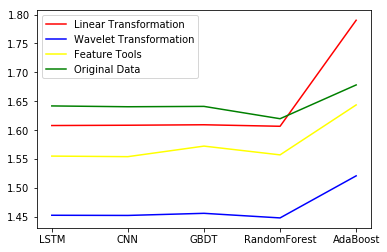

In [3]:
import matplotlib.pyplot as plt

raw_data_accs = [1.6420239050048966, 1.6406177202536136, 1.6412394080028718, 1.6199134532344999, 1.6783490146996896]
plt.figure()
plt.plot(['LSTM', 'CNN', 'GBDT', 'RandomForest', 'AdaBoost'], accs, color='red', label='Linear Transformation')
plt.plot(['LSTM', 'CNN', 'GBDT', 'RandomForest', 'AdaBoost'], accs2, color='blue', label='Wavelet Transformation')
plt.plot(['LSTM', 'CNN', 'GBDT', 'RandomForest', 'AdaBoost'], accs3, color='yellow', label='Feature Tools')
plt.plot(['LSTM', 'CNN', 'GBDT', 'RandomForest', 'AdaBoost'], raw_data_accs, color='green', label='Original Data')
plt.legend()

### Now we try to use wt, SAE & LSTM to do stock predicting

In [3]:
"""
First Step : Using Wavelet Transformation to wipe out noise
"""
train_input, train_label, dev_input, dev_label, test_input, test_label = generate_by_wavelet(N, seq_len, sample_gap)
print(train_input.shape)

(15091, 30, 28)


In [26]:
"""
Second Step : Using SAE to get high level features
"""
train_input = train_input.reshape(train_input.shape[0], -1)
train_input -= np.mean(train_input)
train_input /= np.std(train_input)

dev_input = dev_input.reshape(dev_input.shape[0], -1)
dev_input -= np.mean(dev_input)
dev_input /= np.std(dev_input)

test_input = test_input.reshape(test_input.shape[0], -1)
test_input -= np.mean(test_input)
test_input /= np.std(test_input)

SAE = Sequential()

SAE.add(Dense(128, input_shape=(840, ), activation='relu'))
SAE.add(Dense(840, activation='sigmoid'))

SAE.compile(optimizer='adam', loss='mse')
SAE.summary()

SAE.fit(train_input, train_input, epochs=5, batch_size=128, verbose=1, validation_data=(dev_input, dev_input))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 128)               107648    
_________________________________________________________________
dense_28 (Dense)             (None, 840)               108360    
Total params: 216,008
Trainable params: 216,008
Non-trainable params: 0
_________________________________________________________________
Train on 15091 samples, validate on 1886 samples
Epoch 1/5
15091/15091 [==============================] - 3s 184us/step - loss: 0.7711 - val_loss: 0.7309
Epoch 2/5
15091/15091 [==============================] - 1s 93us/step - loss: 0.7300 - val_loss: 0.7308
Epoch 3/5
15091/15091 [==============================] - 1s 93us/step - loss: 0.7299 - val_loss: 0.7308
Epoch 4/5
15091/15091 [==============================] - 2s 102us/step - loss: 0.7299 - val_loss: 0.7308
Epoch 5/5
15091/15091 [==============================] - 2s 110us

In [27]:
"""
Third Step : Using LSTM to do regression
"""
def LSTMModel(train_input, train_label, dev_input, dev_label, test_input, test_label):
    model = Sequential()
    model.add(LSTM(128, input_length=train_input.shape[1], input_dim=train_input.shape[2], return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(10))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()

    callback = EarlyStopping(monitor="loss", patience=0.01, verbose=1, mode="auto")
    model.fit(train_input, train_label, epochs=3, batch_size=32, validation_data=(dev_input, dev_label), callbacks=[callback])

    LSTMIndicatorPred = model.predict(test_input)
    LSTMacc = np.std(LSTMIndicatorPred - test_label.reshape(test_label.shape[0], 1))
    return LSTMacc

new_train = SAE.predict(train_input)
new_dev = SAE.predict(dev_input)
new_test = SAE.predict(test_input)

new_train = new_train.reshape(new_train.shape[0], seq_len, 28)
new_dev = new_dev.reshape(new_dev.shape[0], seq_len, 28)
new_test = new_test.reshape(new_test.shape[0], seq_len, 28)

acc = LSTMModel(new_train, train_label, new_dev, dev_label, new_test, test_label)
print(acc)

/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/Users/quan/Library/Python/3.5/lib/python/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, return_sequences=True, input_shape=(30, 28))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 128)           80384     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_29 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 11        
Total params: 116,705
Trainable params: 116,705
Non-trainable params: 0
_________________________________________________________________
Train on 15091 samples, validate on 1886 samples
Epoch 1/3
15091/15091 [==============================] - 49s 3ms/step - loss: 2.2097 - val_loss: 2.3102
Epoch 2/3
15091/15091 [==============================] - 45s 3ms/step - loss: 2.2075 - val_loss: 2.3094
Epoch 3/3
1